In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
import networkx as nx


Here is a little function that provides you with a handful of information about your current network

In [3]:

def Ginfo(G):
    info = []
    info.append(f"Graph Name: {G.name}")
    info.append(f"Graph Type: {type(G).__name__}")
    info.append(f"Number of Nodes: {G.number_of_nodes()}")
    info.append(f"Number of Edges: {G.number_of_edges()}")
    info.append(f"Density: {round(100. * nx.density(G), 3)} %")

    if nx.is_weighted(G):
        info.append(f"Weighted: Yes")
        avg_weighted_degree = sum(weight for u, v, weight in G.edges(data=True)) / G.number_of_nodes()
        info.append(f"Average Weighted Degree: {round(avg_weighted_degree, 2)}")
    else:
        info.append(f"Weighted: No")
        avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
        info.append(f"Average Degree: {round(avg_degree, 2)}")

    is_connected = nx.is_connected(G)
    info.append(f"Connected: {'Yes' if is_connected else 'No'}")
    num_components = nx.number_connected_components(G)
    info.append(f"Number of Connected Components: {num_components}")

    if not is_connected:
        # Calculate diameter of the largest connected component
        largest_cc = max(nx.connected_components(G), key=len)
        subgraph = G.subgraph(largest_cc)
        diameter = nx.diameter(subgraph)
        info.append(f"Diameter of Largest Connected Component: {diameter}")
        avgspl = nx.average_shortest_path_length(subgraph)
        info.append(f"<spl> of Largest Connected Component: {avgspl}")

    else:
        diameter = nx.diameter(G)
        info.append(f"Diameter: {diameter}")
        avgspl = nx.average_shortest_path_length(G)
        info.append(f"<spl>: {avgspl}")

    info.append(f"Directed: {'Yes' if G.is_directed() else 'No'}")
    
    return print("\n".join(info))



## robustness and vulnerablity

Within the last coding exercise we have learned about centrality measures that indicate the structural importance of a node.
Another way to think about the relative importance of nodes in a network is to measure how much it would damage the network structure if particular nodes were to be removed. In real life, node removal might be a person moving away and out of a social network, someone changing jobs and being removed from an email network, internet routers being attacked or powergrids being overloaded etc.

Broadly, we consider two types of network damage: random failure and targeted attack. In a random failure, nodes are chosen randomly for removal. In a targeted attack, we will remove nodes based on their 'role' in the network, for example, removing nodes in decreasing order of their degree centrality.


### Random failure

Whenever we're going to engage in a distructive process, we want to make a copy of the network graph to attack so that we can easily get back to the original state:

In [5]:

G_rnd = nx.gnp_random_graph(100,.2)
largest_cc = max(nx.connected_components(G_rnd), key=len)
G = nx.subgraph(G_rnd,largest_cc) 

print(Ginfo(G))

C = G.copy()


Graph Name: 
Graph Type: Graph
Number of Nodes: 100
Number of Edges: 1050
Density: 21.212 %
Weighted: No
Average Degree: 21.0
Connected: Yes
Number of Connected Components: 1
Diameter: 3
<spl>: 1.7975757575757576
Directed: No
None


To simulate random failure, we randomly choose some node names and remove them from the graph. We can use `random.sample` to remove more than one node at at time. Note that we need to make a `list` of node names from which to randomly sample:

In [7]:
import random
n = 2
nodes_to_remove = random.sample(list(C.nodes), 2)
print('list of %s random nodes to be removed' %n)
print(nodes_to_remove)
C.remove_nodes_from(nodes_to_remove)

list of 2 random nodes to be removed
[31, 77]


The full simulation is going to work like this, beginning from a fresh copy of the network:

1. Measure size of the largest-connected component as compared to the original network size
2. Select M nodes at random and remove them
3. Repeat until there are less than M nodes

We'll determine M from how many steps we want this process to take. Around 25 steps should be good, so:

In [12]:
number_of_steps = 25
M = G.number_of_nodes() // number_of_steps
print('# nodes to remove in each step: %s' %M)
num_nodes_removed = range(0, G.number_of_nodes(), M)


# nodes to remove in each step: 4


The loop is fairly simple. At each step, we need to record the fraction of remaining nodes in the lcc.

In [13]:
N = G.number_of_nodes()
C = G.copy()
relative_lcc_size = []
for nodes_removed in num_nodes_removed:
    # Measure the relative size of the network core
    lcc = largest_cc = max(nx.connected_components(C), key=len)
    lcc_share = len(lcc) / N
    relative_lcc_size.append(lcc_share)
    
    # If there are more than M nodes, select M nodes at random and remove them
    if C.number_of_nodes() > M:
        nodes_to_remove = random.sample(list(C.nodes), M)
        C.remove_nodes_from(nodes_to_remove)

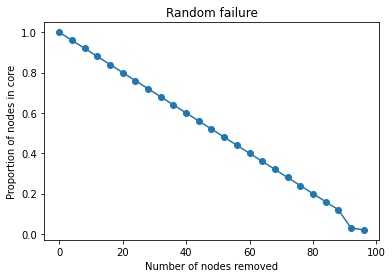

In [14]:
plt.title('Random failure')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.plot(num_nodes_removed, relative_lcc_size, marker='o')

# Targeted attack

## Exercise 1 -- random network (10 pts)

In simulating a targeted attack on the network, you will remove nodes based on their centrality, but unlike a random attack, you will target the most central nodes.
However, keep in mind that the structural properties change after node removal! 

Consider the same random network used above for the random attack.

Simulate a targeted attack to the most central nodes according to

o nodes sorted by degree centrality 

o nodes sorted by closeness centrality

o nodes sorted by betweeness centrality.

Hint: Before each removal step, re-calculate the centrality of all nodes in the current network.

Determine which kind of attack leads to the most vulnerable results by e.g. plotting them together in one figure.


# Exercise 2 -- real-world data (8 pts)

Simulate targeted attacks against the power grid of the American states in the west and find the most vulnerable nodes. (dataset: `powergrid.edgelist.txt`)

Use only degree- and closeness centrality here. (Computing betweeness centrality is too expensive.)

o First compare the set of the 5 highest-degree-nodes with the set of the highest-closeness-nodes. What do you notice?

o Iterate through the node lists according to both centrality measures. You don't need to go through the complete node list. There is a maximal number of nodes to remove.

o Use a meaningful step size M for calculating closeness centrality. It is computationally expensive, too.

(My loop ran about 10 mins so don't panic if your script is a little busy finishing the task. However, it should also not run much longer. You can control it by setting the number of steps and the endpoint of your iteration.)

o Compare your results together with random failure.


